# <center> Hands-on Session 2</center>
## <center> Explainable Graph-based Representations in Digital Pathology</center>

**Presented by:**
- Guillaume Jaume
    - Pre-doc researcher with EPFL & IBM Research 
    - gja@zurich.ibm.com  
<br/>
- Pushpak Pati 
    - Pre-doc researcher with ETH & IBM Research
    - pus@zurich.ibm.com

## Part 1: From pixel- to entity-based representations: Aligning AI's processing with doctors 

The  first part of this tutorial will guide you to build **interpretable entity-based representations** of tissue regions.

Intuitively, the motivation is the following:

- Most of the deep learning approaches for modeling tissues operate on raw images, *i.e.,* they do pixel-based processing. 
    - Straightforward approach where we can leverage advances in computer vision, *e.g.,* with ConvNets. 
    - But, the input, *i.e.,* the pixels, is completely detached from the way pathologists look at the image.
- Instead doctors reason with abstract objects based on their medical/biological understanding. For instance, they reason with:
    - nuclei: their type, shape, texture, how they are organised, etc.
    - tissue regions: glands, shape of the epithelium region, etc.
- We propose to move the basic units of explanation from pixels to biological entities.
- We use the flexibility of graphs, that naturally encode entities and their interactions, to transform the images into biological graphs. In this tutorial, we will focus on nuclei to build **cell graphs**. A similar approach can naturally be extended to other entities. 

### <center> "*Pathologists can now relate to and reason with the input.*" </center> 

![Example of biology-based tissue representations.](Figures/intro_part1.png)

**References:**

- [CGC-Net: Cell Graph Convolutional Network for Grading of Colorectal Cancer Histology Images.](https://arxiv.org/pdf/1909.01068.pdf) Zhou et al., CVPR-W, 2019.
- [Hierarchical Graph Representations in Digital Pathology.](https://arxiv.org/pdf/2102.11057.pdf) Pati et al., MEDIA, 2021.

### 1.A.) Installation and Downloading Data 

- Installation of the *histocartography* library, a Python-based library to ease the development of Computational Pathology projects. Documentation and examples can be checked [here](https://github.ibm.com/GraphsZRL/histocartography).
- Downloading samples from the BRACS dataset, a large cohort of H&E breast cancer tissues. More information and download link to the whole dataset can be found [here](). 

In [ ]:
# installation
!pip install histocartography 
!pip install mpld3

In [ ]:
# @TODO: download some samples, less than 10, should not take more than 10 sec, even with low connexion. 
# downloading samples 
from histocartography.utils.io import download_test_samples
download_test_samples('samples')  # @TODO: add this feature to the library 

### 1.B.) Image-to-Graph: Transforming an image into a cell-graph

This code will allow you to build a cell-graph from an H&E image. The step-by-step protocol is:

- Nuclei detection with HoverNet
- Feature extraction to characterize the nuclei, *i.e.,* the nodes of the cell graph 
- k-NN graph building defining the interactions between the nuclei

**References:**

- [Hover-Net: Simultaneous segmentation and classification of nuclei in multi-tissue histology images.](https://arxiv.org/pdf/1812.06499.pdf) Graham et al., MEDIA, 2019.

In [ ]:
import numpy as np
import torch 
import os 
from glob import glob
from dgl.data.utils import save_graphs
from PIL import Image
from tqdm import tqdm  

# @TODO: replace by actual lib when ready 
import sys
sys.path.append('/Users/gja/Documents/PhD/histocartography/')

from histocartography.preprocessing import NucleiExtractor, DeepFeatureExtractor, KNNGraphBuilder
from histocartography.visualization import OverlayGraphVisualization, InstanceImageVisualization

import warnings
warnings.filterwarnings("ignore")

out_path = '../'
os.makedirs(os.path.join(out_path, 'cell_graphs'), exist_ok=True)

# Define nuclei extractor: HoverNet pre-trained on the PanNuke dataset. 
nuclei_detector = NucleiExtractor()

# Define a deep feature extractor with ResNet34 and patches 72 (max size of nuclei at 40x)
feature_extractor = DeepFeatureExtractor(architecture='resnet34', patch_size=72)

# Define a graph builder to build a DGLGraph object 
graph_builder = KNNGraphBuilder(k=5, thresh=50, add_loc_feats=True)

# Define visualization tools to look at the output 
visualizer = OverlayGraphVisualization(
    instance_visualizer=InstanceImageVisualization(
        instance_style="filled+outline", colormap="jet"
    )
)

# Load image fnames to process @TODO: change path when lib ready 
image_fnames = glob(os.path.join('../../histocartography/test/data/images/', '*.png'))
image_fnames = [image_fnames[-1]]

for image_name in tqdm(image_fnames):

    # 1. load image
    image = np.array(Image.open(image_name))

    # 2. nuclei detection 
    nuclei_map, nuclei_centroids = nuclei_detector.process(image)

    # 3. nuclei feature extraction 
    features = feature_extractor.process(image, nuclei_map)

    # 4. build the cell graph
    cell_graph = graph_builder.process(
        structure=nuclei_centroids,
        features=features,
        image_size=(image.shape[1], image.shape[0])
    )

    # 5. print graph properties
    print('Number of nodes:', cell_graph.number_of_nodes())
    print('Number of edges:', cell_graph.number_of_edges())
    print('Node features:', cell_graph.ndata['feat'].shape)
    print('Node centroids:', cell_graph.ndata['centroid'].shape)

    # 6. save DGL graph
    fname = image_name.replace('.png', '.bin')
    save_graphs(os.path.join(out_path, 'cell_graphs', fname), [cell_graph])

In [ ]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

# Visualize the nuclei detection 
visualizer = InstanceImageVisualization()
viz_nuclei = visualizer.process(image, instance_map=nuclei_map)

f, ax = plt.subplots(1, 1, figsize=(10,10))
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(viz_nuclei)
plt.show()

In [ ]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

# Visualize the resulting cell graph 
visualizer = OverlayGraphVisualization(
    instance_visualizer=InstanceImageVisualization(
        instance_style="filled+outline", colormap="jet"
    )
)
viz_cg = visualizer.process(
  canvas=image,
  graph=cell_graph,
  instance_map=nuclei_map
)

f, ax = plt.subplots(1, 1, figsize=(10,10))
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(viz_cg)
plt.show()

## Part 2: Model prediction & understanding: Identifying important entities

The second part of this tutorial is dedicated to learning with cell-graphs and understanding the behaviour of black-box neural networks operating on (the interpretable) cell-graphs. 

**References:**

- [Towards Explainable Graph Representations in Digital Pathology.](https://arxiv.org/pdf/2007.00311.pdf) Jaume et al., ICML-W, 2020. 
- [Quantifying Explainers of Graph Neural Networks in Computational Pathology.](https://arxiv.org/pdf/2011.12646.pdf) Jaume et al., CVPR, 2021.

### 2.A.) Classifying the cell-graph with a Graph Neural Network 

Given the set of cell graphs generated for the 4000 H&E images of the BRACS dataset, a Graph Neural Network (GNN) was trained to classify each sample as either *Benign*, *Atypical* or *Malignant*. A GNN is an artifical neural network designed to operate on graph-structured data. They work in an analogous way as Convolutional Neural Networks (ConvNets). For each node, a GNN layer is aggregating and updating information from its neighbors to contextualize the node feature representation. More information about GNNs can be found [here](https://github.com/guillaumejaume/graph-neural-networks-roadmap).

**References:**

- [Benchmarking Graph Neural Networks.](https://arxiv.org/pdf/2003.00982.pdf) Dwivedi et al., NeurIPS, 2020. 

In [2]:
import os 
import yaml 

# @TODO: replace by actual lib when ready 
import sys
sys.path.append('/Users/gja/Documents/PhD/histocartography/')

from histocartography.ml import CellGraphModel 

# 1. load CG-GNN config 
config_fname = os.path.join('config', 'cg_bracs_cggnn_3_classes_gin.yml')
with open(config_fname, 'r') as file:
    config = yaml.load(file)

# 2. declare cell graph model: A pytorch model for predicting the tumor type given an input cell-graph
model = CellGraphModel(
    gnn_params=config['gnn_params'],
    classification_params=config['classification_params'],
    node_dim=514,
    num_classes=3,
    pretrained=True
)

# 3. print model 
print('PyTorch Model is defined as:', model)

Using backend: pytorch
/Users/gja/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  del sys.path[0]


PyTorch Model is defined as: CellGraphModel(
  (cell_graph_gnn): MultiLayerGNN(
    (layers): ModuleList(
      (0): GINLayer(
        (mlp): MLP(
          (activation): ReLU()
          (mlp): ModuleList(
            (0): Sequential(
              (fc): Linear(in_features=514, out_features=64, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relu): ReLU()
            )
            (1): Sequential(
              (fc): Linear(in_features=64, out_features=64, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
        )
      )
      (1): GINLayer(
        (mlp): MLP(
          (activation): ReLU()
          (mlp): ModuleList(
            (0): Sequential(
              (fc): Linear(in_features=64, out_features=64, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relu): ReLU()
            )
            (1): Sequential(
              (fc): Linear(in_features=64, out_features=64, bias=Tr

### 2.B.) Apply GradCAM to the CG-GNN

As presented in the first hands-on session, GradCAM is a popular (post-hoc) feature attribution method that allows to highlight regions of the input that are activated by the neural network, *i.e.,* elements of the input that *explaining* the prediction. As the input is now an *interpretable* biologically-defined input space, the explanation is also biologically defined. We use a modified version of GradCAM that can work with GNNs: GraphGradCAM. 

**Note:** GraphGradCAM is one method to derive input-level importance scores. There exists a rich literature proposing other approaches. For instance, the GNNExplainer, GraphGradCAM++, GraphLRP etc.

**References:**

- [Grad-CAM : Visual Explanations from Deep Networks.](https://arxiv.org/pdf/1610.02391.pdf) Selvaraju et al., ICCV, 2017. 
- [Explainability methods  for graph  convolutional  neu-ral  networks.](https://openaccess.thecvf.com/content_CVPR_2019/papers/Pope_Explainability_Methods_for_Graph_Convolutional_Neural_Networks_CVPR_2019_paper.pdf) Pope et al., CVPR, 2019. 

In [15]:
import torch 
from glob import glob 
import tqdm 
import numpy as np
from PIL import Image
from dgl.data.utils import load_graphs

from histocartography.interpretability import GraphGradCAMExplainer
from histocartography.utils.graph import set_graph_on_cuda

is_cuda = torch.cuda.is_available()

# 1. Define a GraphGradCAM explainer
explainer = GraphGradCAMExplainer(model=model)

# 2. Load preprocessed cell graphs & images (for viz) @TODO: make path agnostic 
cg_fnames = glob(os.path.join('../../histocartography/test/data/cell_graphs/', '*.bin'))
cg_fnames = [cg_fnames[-1]]  # dev with only one sample 

image_fnames = glob(os.path.join('../../histocartography/test/data/images/', '*.png'))
image_fnames = [image_fnames[-1]]  # dev with only one sample 

# 3. Explain all our samples 
output = []
for cg_name, image_name in zip(cg_fnames, image_fnames):

  image = np.array(Image.open(image_name))
  
  graph, _ = load_graphs(cg_name)
  graph = graph[0]
  graph = set_graph_on_cuda(graph) if is_cuda else graph

  importance_scores, logits = explainer.process(
      graph,
      output_name=cg_name.replace('.bin', '')
  )
  
  output.append({
    'image': image,
    'graph': graph,
    'importance_scores': importance_scores,
    'logits': logits
  })

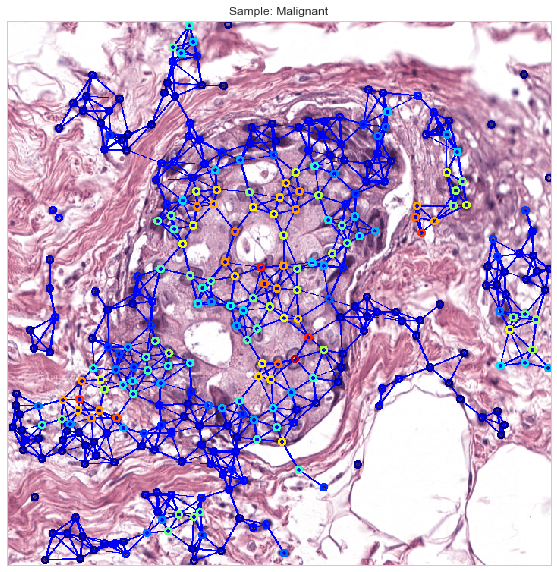

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
import mpld3
mpld3.enable_notebook()

from histocartography.visualization import OverlayGraphVisualization, InstanceImageVisualization

INDEX_TO_TUMOR_TYPE = {
  0: 'Benign',
  1: 'Arypical',
  2: 'Malignant'
}

# Visualize the cell graph along with its relative node importance 
visualizer = OverlayGraphVisualization(
    instance_visualizer=InstanceImageVisualization(),
    colormap='jet',
    show_colormap=True
)
f, ax = plt.subplots(1, len(output), figsize=(10,10))

for i, instance in enumerate(output):
  
  node_attributes = {}
  node_attributes["color"] = instance['importance_scores']
  node_attributes["thickness"] = 3
  node_attributes["radius"] = 5

  viz_cg = visualizer.process(
    canvas=instance['image'],
    graph=instance['graph'],
    node_attributes=node_attributes,
  )
  
  ax.set_title('Sample: {}'.format(
    INDEX_TO_TUMOR_TYPE[np.argmax(instance['logits'])])
              )
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(viz_cg)
  
plt.show()

### 2.C.) These nodes are important, ok, but why? 

We were able to identify what are the important nuclei, *i.e.,* the discriminative nodes, using GraphGradCAM. We would like to push our analysis one step further by understanding if attributes (shape, size, etc.) of the important nuclei are matching some prior knowledge. For instance, it is known that cancerous nuclei are larger than benign ones or that atypical nuclei are expected to have irregular shapes.

To this end, we extract a set of nuclei-level attributes on the most important nuclei.

**Note**: A *quantitative* analysis can be performed by studying nuclei-concept distributions and how they align with prior pathological knowledge. However, this analysis is beyond the scope of this tutorial. The reader can refer to [1](https://arxiv.org/pdf/2011.12646.pdf) for more details. 

**References:**

- [Quantifying Explainers of Graph Neural Networks in Computational Pathology.](https://arxiv.org/pdf/2011.12646.pdf) Jaume et al., CVPR, 2021.